# Dataset exploration - MIT BIH

# Imports

In [1]:
# install all imports (also later ones) on the jupyter notebook silently if necessary, but check if already installed
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade numpy pandas matplotlib seaborn scikit-learn
!{sys.executable} -m pip install --upgrade jupyter
!{sys.executable} -m pip install --upgrade jax wfdb scienceplots optax


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
Using cached pip-24.0-py3-none-any.whl (2.1 MB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 50.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 49.5 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━

In [2]:
# native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing 
# WFDB signals and annotations
import wfdb 
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import jax 
import jax.numpy as jnp
import optax
from torch.utils.data import DataLoader

plt.style.use(['science', 'notebook', 'grid'])
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"

In [3]:
# check if the dataset 'mit-bih-arrhythmia-database-1.0.0' exists in the current directory
if not os.path.isdir('mit-bih-arrhythmia-database-1.0.0'):
    # download the dataset from Physionet
    print('Missing data in the current directory')
    # check if the dataset is in the parent directory
    if os.path.isdir('../mit-bih-arrhythmia-database-1.0.0'):
        print('Data found in the parent directory')
        data_dir = '../mit-bih-arrhythmia-database-1.0.0'
    else: 
        print('Missing data in the parent directory')

Missing data in the current directory
Data found in the parent directory


In [4]:
batch_size=64

# custom collate function
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    
    spks = np.stack(transposed_data[0])
    labels= np.array(transposed_data[1])

    return spks, labels

# Full dataset

In [5]:
# read from the folder all the records number
records = []
symbols = []
samples = []
patient_ids = []
for patient_id in os.listdir(data_dir):
    if not patient_id.endswith('.atr'):
        continue
    pid = patient_id.split('.')[0]
    if pid == '102-0':
        continue
    record = wfdb.rdrecord(os.path.join(data_dir, pid))
    annotation = wfdb.rdann(os.path.join(data_dir, pid), 'atr')
    records.append(record.p_signal)
    symbols.append(np.array(annotation.symbol))
    samples.append(annotation.sample)
    patient_ids.append(int(pid))
print(f'Number of patients: {len(patient_ids)}')
print(f'Patient ids: {patient_ids}')


Number of patients: 48
Patient ids: [118, 124, 119, 122, 123, 121, 109, 108, 219, 231, 230, 232, 233, 223, 222, 220, 234, 208, 209, 221, 210, 205, 213, 207, 212, 202, 203, 217, 201, 215, 228, 214, 200, 111, 105, 104, 106, 112, 113, 107, 103, 117, 116, 102, 114, 100, 101, 115]


In [6]:
# sort the patient ids in ascending order 
patient_ids = np.array(patient_ids, dtype=np.uint8)
argsort_ids = np.argsort(patient_ids)
patient_ids_sort = patient_ids[argsort_ids]
records_sort = np.array(records)[argsort_ids]
symbols_sort = [] ; samples_sort = [] # can't use np.array() because the length of each item is different
for i in range(len(symbols)):
    symbols_sort.append(symbols[argsort_ids[i]])
    samples_sort.append(samples[argsort_ids[i]])

In [7]:
# Make sure that the records are sorted correctly
print(f'patient_ids_sort[0]: {patient_ids_sort[0]} - recovered in position: {argsort_ids[0]}')
print(np.array_equal(records_sort[0], records[argsort_ids[0]]))
print(np.array_equal(symbols_sort[0], symbols[argsort_ids[0]]))
print(np.array_equal(samples_sort[0], samples[argsort_ids[0]]))

for i in range(48):
    assert np.array_equal(records_sort[i], records[argsort_ids[i]]), f'Records: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'
    assert np.array_equal(symbols_sort[i], symbols[argsort_ids[i]]), f'Symbols: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'
    assert np.array_equal(samples_sort[i], samples[argsort_ids[i]]), f'Samples: Not equal for patient_ids_sort[{i}] - recovered in position: {argsort_ids[i]}'

patient_ids_sort[0]: 100 - recovered in position: 45
True
True
True


In [10]:
Xs = [] ; ys = []
classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'U']
nb_removed = np.zeros(48)
hr_factor = (650000/(360 * 60))**(-1)
hr_patients = np.zeros(48)
smaller_ipi = np.zeros(48) # smaller inter-pulse interval
classes_repartition = np.zeros((48, 5))
for i in range(48): # for every patient
    len_samples = len(samples_sort[i])
    samples_sort[i] = samples_sort[i][np.in1d(symbols_sort[i], classes)] # select only the samples corresponding to the desired classes
    symbols_sort[i] = symbols_sort[i][np.in1d(symbols_sort[i], classes)] # select only the symbols corresponding to the desired classes
    nb_removed[i] = len_samples - len(samples_sort[i]) # compute the number of removed samples from the selection process
    hr_patients[i] = len(samples_sort[i])*hr_factor    # compute the heart rate 
    smaller_ipi[i] = np.min(np.diff(samples_sort[i]))  # compute the smallest inter-pulse interval

    # replace the symbols with the corresponding class
    symbols_sort[i][np.in1d(symbols_sort[i], ['N', 'L', 'R', 'e', 'j'])] = 0
    symbols_sort[i][np.in1d(symbols_sort[i], ['A', 'a', 'J', 'S'])] = 1
    symbols_sort[i][np.in1d(symbols_sort[i], ['V', 'E'])] = 2
    symbols_sort[i][np.in1d(symbols_sort[i], ['F'])] = 3
    symbols_sort[i][np.in1d(symbols_sort[i], ['/', 'f', 'U'])] = 4
    symbols_sort[i] = symbols_sort[i].astype(np.int8)
    
    # compute the classes repartition
    values, counts = np.unique(symbols_sort[i], return_counts=True)
    for j in range(len(values)):
        classes_repartition[i, values[j]] = counts[j]

In [11]:
# create the dataset
Xs = [] ; ys = [] ; pids = []
safe_half_window = int(np.min(smaller_ipi)*0.8)

# Split Dataset into DS1 and DS2
# DS1: 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230
# DS2: 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234


ds1_pids = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
ds2_pids = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

X1s = []; y1s = []; pids1 = []
X2s = []; y2s = []; pids2 = []
X_208s = []; y_208s = []; pids_208s = []

for i in range(48):
    X = np.zeros((len(samples_sort[i])-2, 2*safe_half_window)) # -2 because the first and last R peaks have shorter windows
    y = np.zeros(len(samples_sort[i])-2)
    for j, s in enumerate(samples_sort[i][1:-1]):
        X[j, :] = records_sort[i][s-safe_half_window:s+safe_half_window, 0] 
        y[j] = symbols_sort[i][j]
    # add to general dataset
    Xs.append(X)
    ys.append(y)
    pids.append(np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i])

    # add to either DS1 or DS2
    if patient_ids_sort[i] in ds1_pids:
        X1s.append(X)
        y1s.append(y)
        pids1.append(np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i])
    elif patient_ids_sort[i] in ds2_pids:
        X2s.append(X)
        y2s.append(y)
        pids2.append(np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i])
    if patient_ids_sort[i] == 208:
        X_208s.append(X)
        y_208s.append(y)
        pids_208s = np.ones(len(y), dtype=np.uint8)*patient_ids_sort[i]
    else: 
        None
        #print(f'{patient_ids_sort[i]} not added to DS1 or DS2')
    
    # print patient data
    #print(f'Patient {patient_ids_sort[i]} - X.shape: {X.shape} - y.shape: {y.shape}')

In [12]:
# concatenate the data
X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0).astype(np.int8)

# make dataset binary: class 0 : healthy, class 1 : arrhythmia (old classes 1-4)
y[y>0] = 1

pids = np.concatenate(pids, axis=0).astype(np.uint8)
print(f'X.shape: {X.shape} - y.shape: {y.shape} - pids.shape: {pids.shape}')

X.shape: (109365, 144) - y.shape: (109365,) - pids.shape: (109365,)


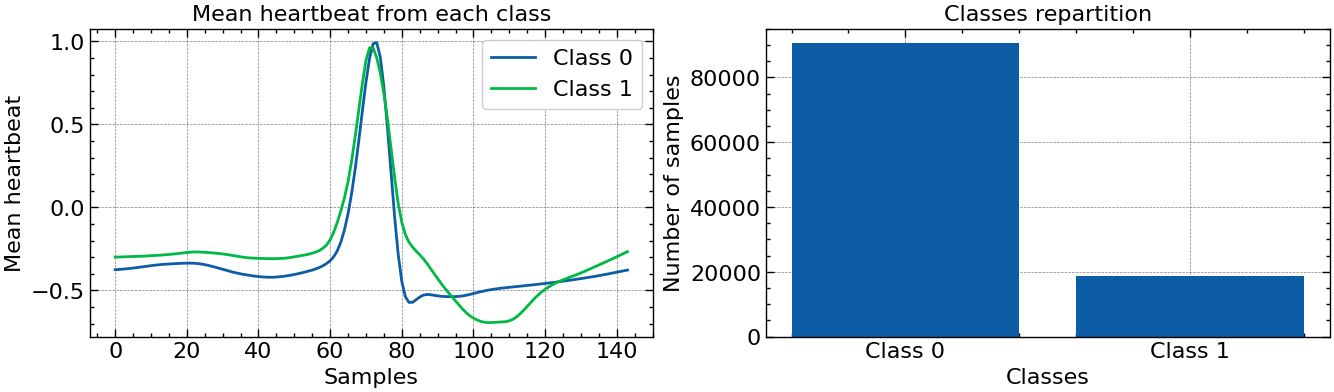

In [13]:
# plot the mean heartbeat from each class and plot the classes repartition using only X and y
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for i in range(2):
    ax[0].plot(np.mean(X[y==i], axis=0), label=f'Class {i}')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Mean heartbeat')
ax[0].set_title('Mean heartbeat from each class')
ax[0].legend()
ax[1].bar(np.arange(2), np.bincount(y), tick_label=[f'Class {i}' for i in range(2)])
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of samples')
ax[1].set_title('Classes repartition')
plt.show()

In [14]:
# concatenate the data of DS1 and DS2
X1 = np.concatenate(X1s, axis=0)
y1 = np.concatenate(y1s, axis=0).astype(np.int8)
# make dataset binary: class 0 : healthy, class 1 : arrhythmia (old classes 1-4)
y1[y1>0] = 1
pids1_np = np.concatenate(pids1, axis=0).astype(np.uint8)
print(f'X1.shape: {X1.shape} - y1.shape: {y1.shape} - pids1.shape: {pids1_np.shape}')

X2 = np.concatenate(X2s, axis=0)
y2 = np.concatenate(y2s, axis=0).astype(np.int8)
# make dataset binary: class 0 : healthy, class 1 : arrhythmia (old classes 1-4)
y2[y2>0] = 1
pids2_np = np.concatenate(pids2, axis=0).astype(np.uint8)
print(f'X2.shape: {X2.shape} - y2.shape: {y2.shape} - pids2.shape: {pids2_np.shape}')

# PATIENT 208

# create dataset X_208 out of X_208s
X_208 = np.concatenate(X_208s, axis=0)
y_208 = np.concatenate(y_208s, axis=0).astype(np.int8)
# make dataset binary: class 0 : healthy
y_208[y_208>0] = 1
print(f'X_208.shape: {X_208.shape} - y_208.shape: {y_208.shape}')

X1.shape: (50969, 144) - y1.shape: (50969,) - pids1.shape: (50969,)
X2.shape: (49661, 144) - y2.shape: (49661,) - pids2.shape: (49661,)
X_208.shape: (2951, 144) - y_208.shape: (2951,)


## Normalization

In [15]:
# normalize X
X_max = np.max(X, axis=0)
X_norm = X / X_max

# DS1
X1_max = np.max(X1, axis=0)
X1_norm = X1 / X1_max

# DS2: test dataset 
# NOTE: -> we don't normalize the test dataset but we use the min and max from the training dataset!!!
X2_norm = X2 / X1_max

# PATIENT 208
X_208_norm = X_208 / X1_max

# always use normalize data
X = X_norm
X1 = X1_norm
X2 = X2_norm
X_208 = X_208_norm


## Balancing

balanced data

In [17]:
# create X_balanced and y_balanced
X_balanced = np.concatenate([X_norm[y==0][:len(y[y==1])], X_norm[y==1]], axis=0)
y_balanced = np.concatenate([y[y==0][:len(y[y==1])], y[y==1]], axis=0)
pids_balanced = np.concatenate([pids[y==0][:len(y[y==1])], pids[y==1]], axis=0)
print(f'X_balanced.shape: {X_balanced.shape} - y_balanced.shape: {y_balanced.shape} - pids_balanced.shape: {pids_balanced.shape}')

# create dataset containing only arrhythmia samples (no class 0 in y)
Xa = X_norm[np.where(y!=0)]
ya = y[np.where(y!=0)]
pidsa = pids[np.where(y!=0)]
print(f'Xa.shape: {Xa.shape} - ya.shape: {ya.shape} - pidsa.shape: {pidsa.shape}')

# create dataset of equal size of Xa containing healthy samples (class 0 in y)
Xh = X_norm[np.where(y==0)]
yh = y[np.where(y==0)]
pidsh = pids[np.where(y==0)]
print(f'Xh.shape: {Xh.shape} - yh.shape: {yh.shape} - pidsh.shape: {pidsh.shape}')

# # creat a balanced dataset out of Xa and Xh
# Xb = np.concatenate((Xh[:len(Xa)//2], Xa), axis=0)
# yb = np.concatenate((yh[:len(Xa)//2], ya), axis=0)
# pidsb = np.concatenate((pidsh[:len(Xa)//2], pidsa), axis=0)
# print(f'Xb.shape: {Xb.shape} - yb.shape: {yb.shape} - pidsb.shape: {pidsb.shape}')

# PATIENT 208 - doesnt really need to be balanced!
X_208_balanced = np.concatenate([X_208_norm[y_208==0][:len(y_208[y_208==1])], X_208_norm[y_208==1]], axis=0)
y_208_balanced = np.concatenate([y_208[y_208==0][:len(y_208[y_208==1])], y_208[y_208==1]], axis=0)

X_balanced.shape: (37630, 144) - y_balanced.shape: (37630,) - pids_balanced.shape: (37630,)
Xa.shape: (18815, 144) - ya.shape: (18815,) - pidsa.shape: (18815,)
Xh.shape: (90550, 144) - yh.shape: (90550,) - pidsh.shape: (90550,)


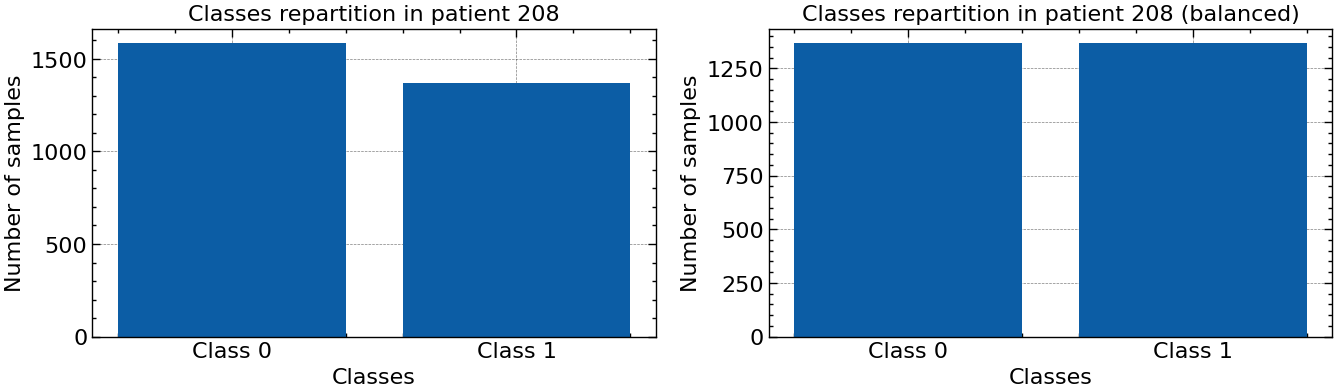

In [19]:
# plot classes repartition in patient 208
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].bar(np.arange(2), np.bincount(y_208), tick_label=[f'Class {i}' for i in range(2)])
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of samples')
ax[0].set_title('Classes repartition in patient 208')
ax[1].bar(np.arange(2), np.bincount(y_208_balanced), tick_label=[f'Class {i}' for i in range(2)])
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of samples')
ax[1].set_title('Classes repartition in patient 208 (balanced)')
plt.show()


## Encoding

### Delta Modulation

#### Defining the threshold

In [639]:
# average signal difference around the R peaks
print(np.mean(np.abs(np.diff(X1_norm[:][50:60]))))

# define threshold accordingly 
thr_X1 = 0.000 # 0.001

0.005755730095906048


In [640]:
# from snntorch tutorial 1
def delta_fn(data, threshold=0.005):
    pos_ch = np.heaviside(np.diff(data)-threshold, 0)
    neg_ch = np.heaviside(-np.diff(data)-threshold, 0)
    return (pos_ch, neg_ch) # 2 channels for positive and negative spikes

### Encode the dataset

In [372]:
# DS1 and DS2 (unbalanced)
X1_spike = delta_fn(X1_norm, threshold=thr_X1)
X2_spike = delta_fn(X2_norm, threshold=thr_X1)

# use balanced dataset
Xbalanced_spike = delta_fn(X_balanced, threshold=thr_X1)

# PATIENT 208
X_208_spike = delta_fn(X_208_norm, threshold=thr_X1)


print(Xbalanced_spike[0].shape)

(37630, 143)


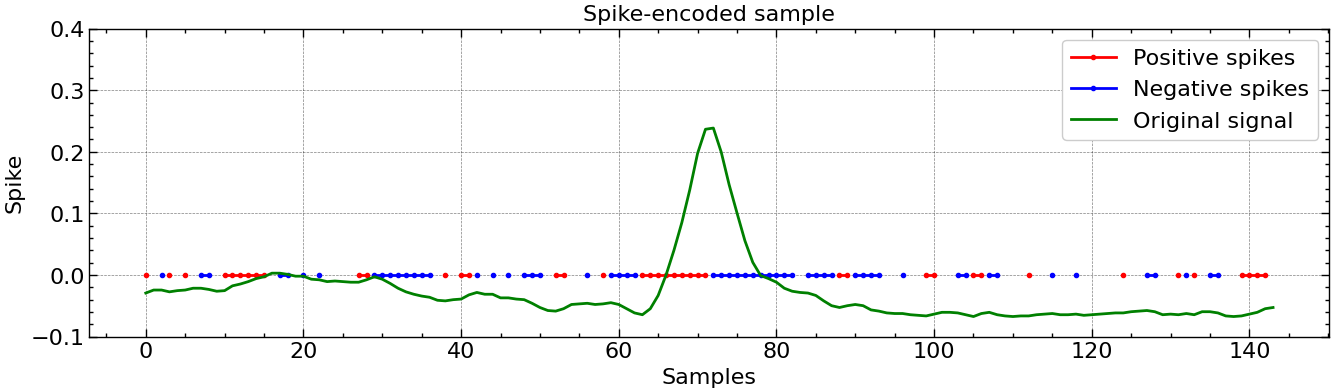

In [373]:
# plot one spike-encoded sample
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
id_sample = 30
pos_ch = X1_spike[0][id_sample]
neg_ch = X1_spike[1][id_sample]
# replace 0 with nan
pos_ch[pos_ch==0] = np.nan
neg_ch[neg_ch==0] = np.nan
# replace 1 with 0 for neg channel
neg_ch[neg_ch==1] = 0
pos_ch[pos_ch==1] = 0
ax.plot(pos_ch, label='Positive spikes', color='r', marker='o', markersize=3)
ax.plot(neg_ch, label='Negative spikes', color='b', marker='o', markersize=3)
# plot the original signal
ax.plot(X1_norm[id_sample], label='Original signal', color='g')
# set y range to -0.1 to 1.1
ax.set_ylim(-0.1, 0.4)
ax.set_xlabel('Samples')
ax.set_ylabel('Spike')
ax.set_title('Spike-encoded sample')
ax.legend()
plt.show()


# Single-Layer SNN

## Function Definition

### Single-Layer SNN

In [634]:
@jax.custom_jvp
def gr_than(x, thr):
    return (x > thr).astype(jnp.float32)

@gr_than.defjvp
def gr_jvp(primals, tangents):
    x, thr = primals
    x_dot, thr_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot * 1 / (jnp.absolute(x-thr)+1)**2
    return primal_out, tangent_out

def lif_forward(state, input_spikes):
    w, out_spikes, I_in, V_mem = state[0]
    tau_mem, Vth, timestep = state[1]
    I_in = jnp.dot(w, input_spikes)
    V_mem = (1 - timestep/tau_mem) * V_mem + I_in # - out_spikes * Vth
    # constraining V_mem to be non-negative
    V_mem = jnp.maximum(0, V_mem)
    out_spikes = gr_than(V_mem, Vth)
    # return state
    return ((w, out_spikes, I_in, V_mem), state[1]), (I_in, V_mem, out_spikes)

### Multi Layer SNN version! --> Meeting with Tristan

In [ ]:
# @jax.custom_jvp
# def gr_than(x, thr):
#     return (x > thr).astype(jnp.float32)

# @gr_than.defjvp
# def gr_jvp(primals, tangents):
#     x, thr = primals
#     x_dot, thr_dot = tangents
#     primal_out = gr_than(x, thr)
#     tangent_out = x_dot * 1 / (jnp.absolute(x-thr)+1)**2
#     return primal_out, tangent_out

# def lif_forward(state, input_spikes):
#     w, out_spikes, I_in, V_mem = state[0]
#     tau_mem, Vth, timestep = state[1]
#     I_in = jnp.dot(w, input_spikes)
#     V_mem = (1 - timestep/tau_mem) * V_mem + I_in - out_spikes * Vth
#     # constraining V_mem to be non-negative
#     V_mem = jnp.maximum(0, V_mem)
#     out_spikes = gr_than(V_mem, Vth)
#     I_in2 = jnp.dot(w, out_spikes)
#     V_mem2 = (1 - timestep/tau_mem) * V_mem + I_in2
#     V_mem2 = jnp.maximum(0, V_mem2)
#     # out_spikes2 = gr_than(V_mem2, Vth)
#     # return state
#     return ((w, out_spikes, I_in, V_mem), state[1]), (I_in, V_mem, out_spikes)

In [375]:
def randomWeightInit(parent_key, scale, in_width, out_width):
    in_width = in_width
    out_width = out_width
    weight_key, bias_key = jax.random.split(parent_key)
    W = scale*jax.random.normal(weight_key, shape=(out_width, in_width)) # random init of [weights, biases] tuple for each layer
    return W

# Tristan's functions

In [376]:
def prediction_per_sample(w, single_input, hyperparams):
    # single_input shape (n_steps, n_in)
    V_mem = jnp.zeros((w.shape[0],),)
    I_in = jnp.zeros((w.shape[0],))
    out_spikes = jnp.zeros((w.shape[0],), dtype='float32')

    #single_input = single_input.swapaxes(0,1) # from old version

    state = ((w, out_spikes, I_in, V_mem), hyperparams)
    _, (I_in, V_mem, out_spikes) = jax.lax.scan(lif_forward, state, single_input)
    return out_spikes, V_mem, I_in


v_prediction_per_sample = jax.vmap(prediction_per_sample, in_axes=(None, 0, None))
#j_v_prediction_per_sample = jax.jit(v_prediction_per_sample, static_argnums=(2,))

# jit the function
j_v_prediction_per_sample = jax.jit(v_prediction_per_sample, static_argnums=(2,))

In [560]:
from sklearn.metrics import f1_score, recall_score, precision_score


def loss_fn(w, batch_spikes, hyperparams, batch_lbls): # , key_noise, delays
    # batch_spikes shape (batch_size, n_steps, n_in)
    out_spikes, V_mem, _ = j_v_prediction_per_sample(w, batch_spikes, hyperparams)
		# V_mem shape (batch_size, 143, 2) in elija's case
    out = V_mem.max(axis=1)

    # computing acc
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == batch_lbls)/len(batch_lbls)

    # computing loss
    logit = jax.nn.softmax(out, axis=1)
    bce_loss = -jnp.mean((jnp.log(logit[jnp.arange(batch_spikes.shape[0]), batch_lbls])))

    # f1 score, recall, precision
    recall = recall_score(batch_lbls, pred, average='binary', zero_division=np.nan)
    precision = precision_score(batch_lbls, pred, average='binary', zero_division=np.nan)
    f1 = f1_score(batch_lbls, pred, average='binary', zero_division=np.nan)

    f1_loss = 1 - f1
    #recall_loss = 1 - recall

    loss = 0.35*bce_loss + 0.65*f1_loss
    
    return loss, (acc, f1, recall, precision)

# jit the function
loss_fn_jit = jax.jit(loss_fn, static_argnums=(2))

In [561]:
def update_opt(w, input_spikes, hyperparams, gt_y, key_noise, delays=0):
    (loss, (acc, f1, recall, precision)), grad = jax.value_and_grad(loss_fn, has_aux=True)(
        w, input_spikes, hyperparams, gt_y
    ) # , key_noise, delays
    return (loss, (acc, f1, recall, precision)), grad

update_opt_jit = jax.jit(update_opt, static_argnums=(2, 4, 5))

## Dataset Class

In [562]:
class ECGDataset():
    def __init__(self, X_dEnc, Y_labels):
        self.pos_spks = X_dEnc[0]
        self.neg_spks = X_dEnc[1]
        self.lbls = Y_labels
    def __len__(self): # return length of dataset, i.e. nb of heart-beat samples (and therefore labels) of all patients
        return self.lbls.shape[0]

    def __getitem__(self, idx):
        return (self.pos_spks[idx], self.neg_spks[idx]), self.lbls[idx]

In [580]:
#train_dataset = ECGDataset(X1_spike, y1) 

# use balanced dataset
train_dataset = ECGDataset(Xbalanced_spike, y_balanced)
#test_dataset = ECGDataset(X2_spike, y2)

# Update Tristan, train and test on Patient 208
#train_dataset = ECGDataset(X_208_spike, y_208)
test_dataset = ECGDataset(X_208_spike, y_208) # Patient 208

## Dataloader

In [581]:
## data loader from pytorch
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

## Training Loop (SL SNN)

### Initialization of Loop 

In [583]:
# on patient 208
# good results f1 : 700 time constant, 0 threshold, 0.03 W, lr 1e-5
# good results f1 : 700 time constant, 0 threshold, 0.05 W, lr 1e-5

# good results f1 : 700 time constant, 0 threshold, 0.5 W, lr 2e-5

In [635]:
num_classes = 2

# initialize state variables of LIF neuron for every time step

# initialize dynamic params
seed = 9
parent_key = jax.random.PRNGKey(seed)
W = randomWeightInit(parent_key, 0.5, 2, num_classes) # 0.4
print(W)
W_init = W
# print absolute mean weight 
print('init mu W', jnp.mean(jnp.abs(W)))
# initalize static params
tau_mem = 2000e-3
V_th = 1.0
timestep = 1e-3

static_params = (tau_mem, V_th, timestep)
hyperparams = (tau_mem, V_th, timestep)
''
num_epochs = 30  

[[-0.0413973   0.47507808]
 [ 0.5211818   0.01320898]]
init mu W 0.26271656


In [636]:
# trying new optimizer with scheduler

start_learning_rate = 1e-5
n_epochs = num_epochs
hp = static_params
#w = W

n_batches = len(train_loader)
n_updates = n_epochs * n_batches
n_updates_lr = 15
transition_steps = np.floor(n_updates / n_updates_lr)
print(f'n_updates: {n_updates}, n_updates_lr: {n_updates_lr}, transition_steps: {transition_steps}')

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=transition_steps,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    #optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = gradient_transform.init(W)

# opt_state = optax.adam(start_learning_rate).init(W)

# define get_params
#get_params = lambda x: x

n_updates: 17610, n_updates_lr: 15, transition_steps: 1174.0


In [637]:
def run_epoch(key, W, loader, hyperparams,
              opt_state,  e=None, opt_update=None, sim_params=0, biased_delays=0, get_params=0):
    local_loss = []
    local_acc = []
    local_f1 = []
    local_recall = []
    local_precision = []
    
    for idx, batch in enumerate(loader):
        #w = get_params(opt_state)
        w = W
        
        batch_in = batch[0] 
        batch_in = batch_in.swapaxes(1,2) # shape (batch_size, n_steps, n_in)
        batch_labels = batch[1]
        key, subkey_noise = jax.random.split(key)
        if e is not None:
            (loss, (acc, f1, recall, precision)), grads = update_opt(w, batch_in, hyperparams, batch_labels, subkey_noise)
            #opt_state = opt_update(e, grads, opt_state)
            updates, opt_state = gradient_transform.update(grads, opt_state) # from old version
            #updates, opt_state = optax.adam(start_learning_rate).update(grads, opt_state)
            #print(W)
            W = optax.apply_updates(W, updates) # from old version
            #print(W)
        else:
            loss, (acc, f1, recall, precision) = loss_fn(w, batch_in, hyperparams, batch_labels, subkey_noise)
        local_loss.append(loss)
        local_acc.append(acc)
        local_f1.append(f1)
        local_recall.append(recall)
        local_precision.append(precision)

    mean_local_loss = np.mean(local_loss) # np.array()
    mean_local_acc = np.mean(local_acc) # np.array()
    mean_local_f1 = np.mean(local_f1) # np.array()
    mean_local_recall = np.mean(local_recall) # np.array()
    mean_local_precision = np.mean(local_precision) # np.array()

    return key, W, opt_state, mean_local_loss, mean_local_acc, mean_local_f1, mean_local_recall, mean_local_precision

### Training Loop 

In [638]:
best_f1 = 0.5
best_acc = 0.5
best_precision = 0.5
best_recall = 0.5

epoch_plot = []
loss_plot = []
acc_plot = []
f1_plot = []
recall_plot = []
precision_plot = []

# create key
key, subkey = jax.random.split(parent_key)

for epoch in range(num_epochs):
    
    W_before = W
    # run epoch
    key, W, opt_state, epoch_loss, epoch_acc, epoch_f1, epoch_recall, epoch_precision = run_epoch(key, W, train_loader, hyperparams, opt_state, e=epoch)

    print('epoch ', epoch, ', e loss ', epoch_loss, ', e acc', epoch_acc, ', f1', epoch_f1, ', precision', epoch_precision, ', recall', epoch_recall, 'dW: ', np.mean(np.abs(W-W_before)))

    # save best performing weight (per epoch)
    if epoch_f1 + epoch_acc + epoch_precision + epoch_recall > best_f1 + best_acc + best_precision + best_recall:
      W_final_2 = W
      best_f1 = epoch_f1
      best_acc = epoch_acc
      best_precision = epoch_precision
      best_recall = epoch_recall

      print('W saved')
      print('')
    
    # save results
    epoch_plot.append(epoch)
    loss_plot.append(epoch_loss)
    acc_plot.append(epoch_acc)
    f1_plot.append(epoch_f1)
    recall_plot.append(epoch_recall)
    precision_plot.append(epoch_precision)

print('DONE')

epoch  0 , e loss  1.3808732 , e acc 0.52273214 , f1 0.6421154275985386 , precision 0.5135834250305629 , recall 0.8662679290958213 dW:  0.0029087581
W saved

epoch  1 , e loss  1.3230097 , e acc 0.5278961 , f1 0.6403936694879575 , precision 0.516598013133869 , recall 0.8519233428224179 dW:  0.0028902378
epoch  2 , e loss  1.2692562 , e acc 0.5321284 , f1 0.6388429084734271 , precision 0.5200803138143081 , recall 0.8370783259072065 dW:  0.002866893


KeyboardInterrupt: 

In [628]:
print('W_init', W_init)
print('W ', W)
print('W_final_2', W_final_2)
print('mean W', jnp.mean(jnp.abs(W_final_2)))

W_init [[-0.0413973   0.47507808]
 [ 0.5211818   0.01320898]]
W  [[0.02952582 0.4682179 ]
 [0.4490784  0.01148504]]
W_final_2 [[-0.03835617  0.47769028]
 [ 0.51784235  0.01056845]]
mean W 0.26111433


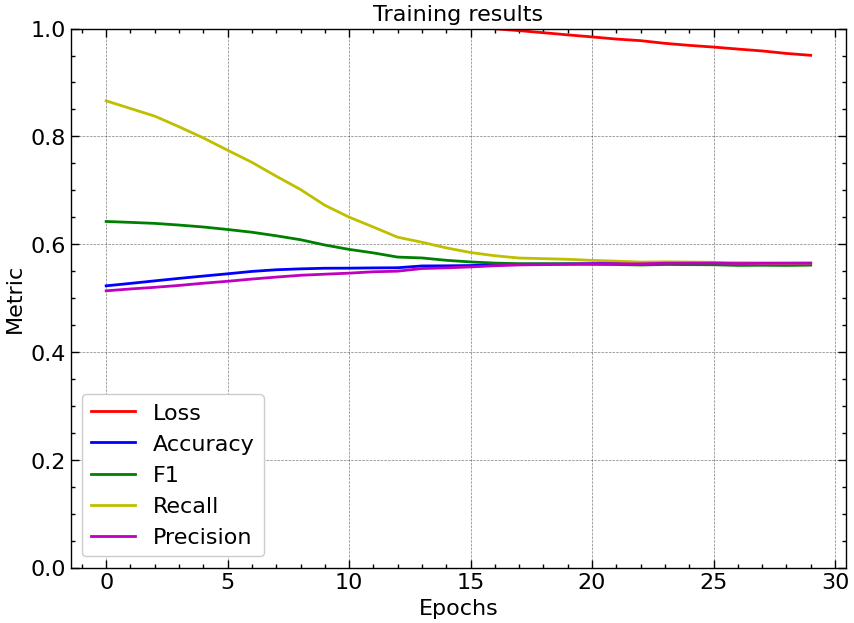

In [629]:
# plot results in a single plot, y from 0 to 1
fig, ax = plt.subplots(1, 1, figsize=(1000*px, 700*px))
ax.plot(epoch_plot, loss_plot, label='Loss', color='r')
ax.plot(epoch_plot, acc_plot, label='Accuracy', color='b')
ax.plot(epoch_plot, f1_plot, label='F1', color='g')
ax.plot(epoch_plot, recall_plot, label='Recall', color='y')
ax.plot(epoch_plot, precision_plot, label='Precision', color='m')
# y range from 0 to 1
ax.set_ylim(0, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Metric')
ax.set_title('Training results')
ax.legend()
plt.show()


## Testing the model

V_mem (64, 143, 2)
out (64, 2)
pred (64,)


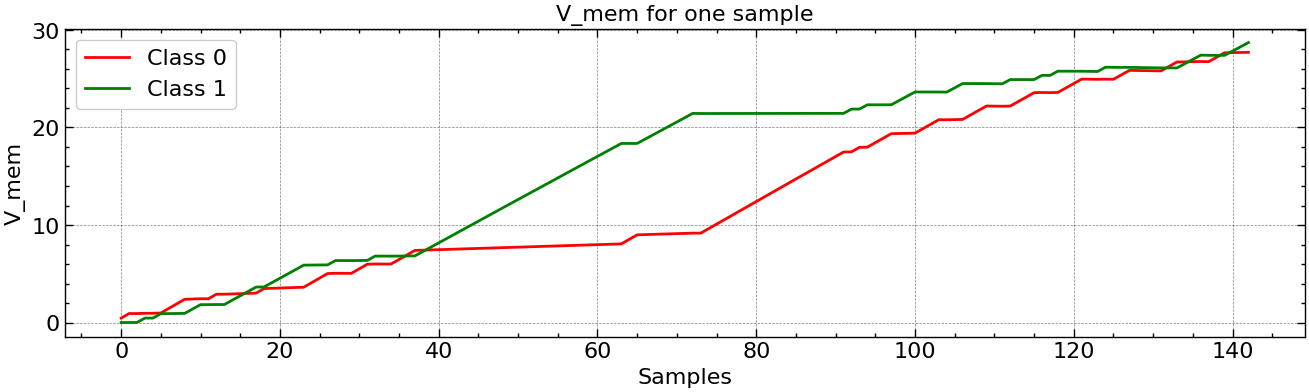

pred 1
lbl 0
lbl batch  [1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1]
pred batch [0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1]


In [630]:
# do inference on one testbatch
# get one batch from test_loader
test_batch = next(iter(test_loader))

#print(W)

spk_batch, lbl_batch = test_batch
spk_batch = spk_batch.swapaxes(1,2) # shape (batch_size, n_steps, n_in)

# # get one sample from the batch
# spks = spk_batch[0]
# lbl = lbl_batch[0]

# # # do inference
# V_mem = jnp.zeros((W.shape[0],),)
# I_in = jnp.zeros((W.shape[0],))
# out_spikes = jnp.zeros((W.shape[0],), dtype='float32')

# state = ((W, out_spikes, I_in, V_mem), hyperparams)
# for i in range(143):
#     state, (I_in, V_mem, out_spikes) = lif_forward(state, spks[i])
#     print('I in', state[0][2])
#     print('V mem', state[0][3])
#     #print('out spikes', state[0][1])

out_spikes, V_mem, I_in = v_prediction_per_sample(W, spk_batch, hyperparams)

print('V_mem', V_mem.shape)
out = V_mem.max(axis=1)
print('out', out.shape)
# computing acc
pred = jnp.argmax(out, axis=1)
print('pred', pred.shape)
# acc = jnp.count_nonzero(pred == lbl_batch)/len(lbl_batch)
# # loss
logit = jax.nn.softmax(out, axis=1)
# binary cross entropy loss
loss = -jnp.mean((jnp.log(logit[jnp.arange(spk_batch.shape[0]), lbl_batch])))
#print('acc: ', acc, 'loss: ', loss)

V_mem = V_mem.swapaxes(1,2) # just for plotting

# plot V_mem for one sample
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
id_sample = 20
ax.plot(V_mem[id_sample][0], label='Class 0', color='r')
ax.plot(V_mem[id_sample][1], label='Class 1', color='g')
# y from 0 to y_max*(1.1) of sample
y_max = np.max(V_mem[id_sample])
ax.set_xlabel('Samples')
ax.set_ylabel('V_mem')
ax.set_title('V_mem for one sample')
ax.legend()
plt.show()

print('pred', pred[id_sample])
print('lbl', lbl_batch[id_sample])

# print first 20 predictions and labels
print('lbl batch ', lbl_batch[:20])
print('pred batch', pred[:20])


In [631]:
# do inference on whole test batch
from sklearn.metrics import f1_score, precision_score, recall_score

acc_t = []
loss_t = []

f1_t = []
precision_t = []
recall_t = []

for idx, batch in enumerate(test_loader):
    spk_batch, lbl_batch = batch
    spk_batch = spk_batch.swapaxes(1,2) # shape (batch_size, n_steps, n_in)
    # do inference
    out_spikes, V_mem, _ = v_prediction_per_sample(W_final_2, spk_batch, hyperparams)
    out = V_mem.max(axis=1)
    # computing acc
    pred = jnp.argmax(out, axis=1)
    acc = jnp.count_nonzero(pred == lbl_batch)/len(lbl_batch)
    # loss
    logit = jax.nn.softmax(out, axis=1)
    loss = -jnp.mean((jnp.log(logit[jnp.arange(spk_batch.shape[0]), lbl_batch])))
    acc_t.append(acc)
    loss_t.append(loss)

    # calculate f1 score, precision and recall
    # TP = jnp.count_nonzero((pred == 1) & (lbl_batch == 1))
    # TN = jnp.count_nonzero((pred == 0) & (lbl_batch == 0))
    # FP = jnp.count_nonzero((pred == 1) & (lbl_batch == 0))
    # FN = jnp.count_nonzero((pred == 0) & (lbl_batch == 1))
    #print('TP: ', TP, 'TN: ', TN, 'FP: ', FP, 'FN: ', FN)
    # precision = TP / (TP + FP) if (TP + FP) != 0.0 else jnp.nan # percent of correctly classified arrh cases out of all predictions
    # recall = TP / (TP + FN) if (TP + FN) != 0 else jnp.nan # percent of detected arrh cases out of all true arrh cases
    # f1 = 2 * (precision * recall) / (precision + recall) # weighted average of precision and recall

    f1 = f1_score(lbl_batch, pred, average='binary', labels=np.unique(pred), zero_division=0)
    precision = precision_score(lbl_batch, pred, average='binary', labels=np.unique(pred), zero_division=0)
    recall = recall_score(lbl_batch, pred, average='binary', labels=np.unique(pred), zero_division=0)
    #print('f1: ', f1, 'precision: ', precision, 'recall: ', recall)

    f1_t.append(f1)
    precision_t.append(precision)
    recall_t.append(recall)
    

print('acc: ', np.mean(acc_t), 'loss: ', np.mean(loss_t), 'f1: ', np.mean(f1_t), 'precision: ', np.mean(precision_t), 'recall: ', np.mean(recall_t))

acc:  0.45210597 loss:  4.3835683 f1:  0.5739198085378533 precision:  0.45617747226693905 recall:  0.8389432154893528


### Confusion Matrix on DS2

[[660 921]
 [467 896]]


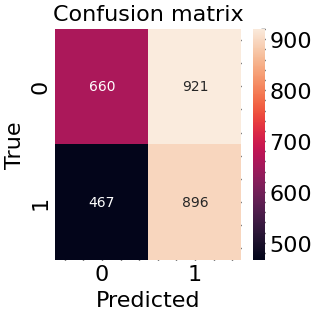

In [632]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report # TODO: implement classification report
import seaborn as sns

# get all predictions
all_preds = []
all_labels = []

for idx, batch in enumerate(test_loader):
    spk_batch, lbl_batch = batch
    spk_batch = spk_batch.swapaxes(1,2) # shape (batch_size, n_steps, n_in)
    # do inference
    out_spikes, V_mem, _ = v_prediction_per_sample(W, spk_batch, hyperparams)
    out = V_mem.max(axis=1)
    # computing acc
    pred = jnp.argmax(out, axis=1)
    all_preds.append(pred)
    all_labels.append(lbl_batch)

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion matrix')
plt.show()


In [633]:
# plot classification report
report = classification_report(all_labels, all_preds, target_names=['Healthy', 'Arrhythmia'], zero_division=0)
print(report)


              precision    recall  f1-score   support

     Healthy       0.59      0.42      0.49      1581
  Arrhythmia       0.49      0.66      0.56      1363

    accuracy                           0.53      2944
   macro avg       0.54      0.54      0.53      2944
weighted avg       0.54      0.53      0.52      2944



# TODO 

- Try Binary Classification first with good accuracy
- SMOTE
- Modify loss function to penalize arrhythmia misclassification more
- Even inside arrythmic heartbeats there is an imbalancement (nb class 4/1 >> nb class 3/2) -> balance this out as well! -> I think I did but the accuracy got actually worse..
- standardization of dataset (on top of normalization)?
- plot confusion matrix

# Questions

- What needs to be changed for the binary cross-entropy loss? I feel the loss is too low for the current performance right?
- 

In [84]:
# TODO
# 1. Print out f1 score, precision and recall !
# 2. Implement Tristan's functions, uncomment mine, and run it